# Background

The threshold used in adaptive localisation is set to $\frac{3}{\sqrt(n)}$ or is user defined.
The following showcases how this does not take into account

1. the multiple comparison problem, requiring a Bonferroni-type correction,
2. leading to localisation not appropriately guarding against spurious correlations,
2. and how this leads to significant increase in unecessary computational costs.

A remedy is proposed as calculating thresholds that appropriately takes into occount the multiple comparison problem.
Interestingly, the same functions may be employed for apriori selecting ensemble sizes guaranteeing for spurious correlations below certain thresholds.

In [28]:
import numpy as np
from scipy import optimize
from scipy.stats import norm
import math
from math import sqrt
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams.update({'font.size': 14})
develop = False
plt.rcParams['text.usetex'] = True
rng = np.random.default_rng()

# Problem illustration: inclusion vs dimension

We first illustrate the problems of the $\frac{3}{\sqrt(n)}$ threshold.

We estimate the expected fraction of an included correlation vector, for a given dimension size of the vector.

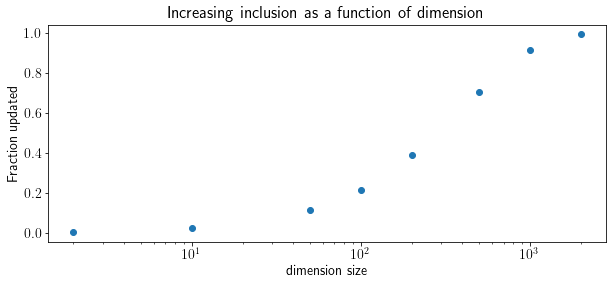

In [29]:
# Number of simulation times
m = 1000
# Ensemble size
n = 100
# Threshold currently used in adaptive localisation
threshold = 3/sqrt(n)
dim_vals = [2, 10, 50, 100, 200, 500, 1000, 2000]
dim_significant = []
for p in dim_vals:    
    significant = []
    for _ in range(m):
        # sample a normal p-vector with independence n times
        x = [np.random.standard_normal(size=p) for _ in range(n)]
        corr = np.corrcoef(x, rowvar=False)
        target_corr = corr[0][1:] # how does other p-1 variables correlate with target?
        res = any(np.absolute(target_corr) > threshold)
        significant.append(res)
    dim_significant.append(np.array(significant).sum() / m)
# Plot inclusion vs dimension
plot1 = plt.figure(1)
plt.scatter(dim_vals, dim_significant)
plt.xscale("log")
plt.title("Increasing inclusion as a function of dimension")
plt.ylabel("Fraction updated")
plt.xlabel("dimension size")
plt.show()

We see that the number of correlation vectors deemed significant (at least one dimension above the threshold) increases with dimension. Why is this? This implies that if only our problem is big enough, then almost all vectors are somehow included, leading to 1. an enormous computational load, and 2. spurious correlations in spite of localisation.

# What underpins the $\frac{3}{\sqrt(n)}$ threshold
The $\frac{3}{\sqrt(n)}$ threshold stems from the asymptotic distribution to the correlation in a bivariate normal distribution. When true underlying $\rho=0$ (implying independence in a normal), the variance is $\frac{1}{n}$ asymptotically. Assuming independence in a $p-$dimensional problem the same result may be extended for any singal correlation in the sample correlation matrix. The problem we observe above, however, results from considering multiple correlation estimates _at the same time_. Indeed, in a regression setting, 5 out of 100 non-predictive covariates are expected to be deemed significant at the 0.05 p-value. The same effect is observed above.


# Threshold with significant confidence

We seek a p-value that provides the following: 
> _Given an $\alpha$-significance level, we find a treshold or p-value $\tau_\alpha$ so that we are $1-\alpha$ certain all $|\hat\rho_i|$'s are below $\tau_\alpha$ under the assumption that all $\rho_i=0$._

We are going to check the magnitude of all $\hat\rho_i$ to be less than some value $\tau_\alpha$.
The magnitude of some $\hat\rho_i$ has the half-normal distribution with $\sigma=\frac{1}{\sqrt n}$ 
where the pdf reads
$$f_{|\hat\rho|}(\rho) = \frac{\sqrt2}{\sigma\sqrt\pi}\exp\left( -\frac{\rho^2}{2\sigma^2}\right) ,~ \rho\geq 0$$ 
and cdf reads
$$F_{|\hat\rho|}(\rho) = 2 F_{\hat\rho}(\rho) - 1$$
Furthermore, let $Y=\max\{X_1,\ldots, X_p\}$, then $Y$ has the CDF
$$F_Y(y) = \prod_i P(X_i\leq y) = F_X(y)^p.$$
Thus, we may find the threshold $\tau_\alpha$
such that $F_Y(y)-(1-\alpha) = 0$
that will guarantee our required probability on some $\tau$.

In [30]:
# Python implementation
def pabs(x, sigma):
    """cdf of half-normal distribution"""
    return 2 * norm.cdf(x, scale=sigma) - 1
   
def pmaxabs(y, dimensions=100, n=100):
    """cdf of max of n half-normally distributed variables"""
    sigma = 1 / sqrt(n)
    return pabs(y, sigma)**dimensions

def qmaxabs(p, dimensions=100, n=100):
    """threshold so that p certain all magnitudes of n-correlation estimates below threshold"""
    f = lambda y: pmaxabs(y, dimensions=dimensions, n=n) - p
    return optimize.brentq(f, 0, 1)

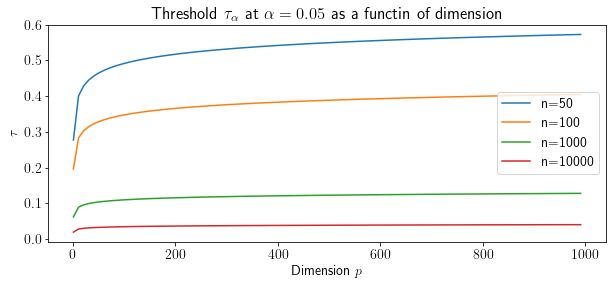

In [31]:
# Threshold versus dimension
alpha = 0.05
dimvals = list(range(1, 1000, 10))
yvals50 = [qmaxabs(1-alpha, d, n=50) for d in dimvals]
yvals100 = [qmaxabs(1-alpha, d, n=100) for d in dimvals]
yvals1000 = [qmaxabs(1-alpha, d, n=1000) for d in dimvals]
yvals10000 = [qmaxabs(1-alpha, d, n=10000) for d in dimvals]
plot2 = plt.figure(2)
plt.plot(dimvals, yvals50)
plt.plot(dimvals, yvals100)
plt.plot(dimvals, yvals1000)
plt.plot(dimvals, yvals10000)
plt.legend(["n=50", "n=100", "n=1000", "n=10000"])
plt.title(r"Threshold $\tau_\alpha$ at $\alpha=0.05$ as a functin of dimension")
plt.ylabel(r"$\tau$")
plt.xlabel(r"Dimension $p$")
plt.show()

As expected the threshold is much higher at small ensemble sizes and is increasing in dimension.
Furthermore, note that $\tau$ does not increase much after e.g. $p=200$.
This is due to the exponential decrease in the tails of the probability distributions of the estimates, 
and it also showcase clearly the importance in the selection of $\tau$ -- with small changes around the significant values a large portion of spurious correlations will be either included or excluded.
Such small changes should not have a large effect on actual significant correlations, as these estimates will be centered around their respctive non-zero population values.

## A note on effective dimension size
Note that the threshold assumes independence among dimensions. 
In practice, for e.g. a parameter random-field, there will be very high dependence structures and the independence assumption will not hold.
Instead of the length of the parameter vector, the effective sample size should instead be employed. E.g. 
$$
\text{dim}(\theta)_\text{eff} = 
\frac{\text{dim}(\theta)}{1+\frac{2}{\text{dim}(\theta)}\sum_{1\leq i < j \leq \text{dim}(\theta)}\text{Corr}(\theta_i,\theta_j)} 
$$

Which may be calculated from the prior on $\theta$.